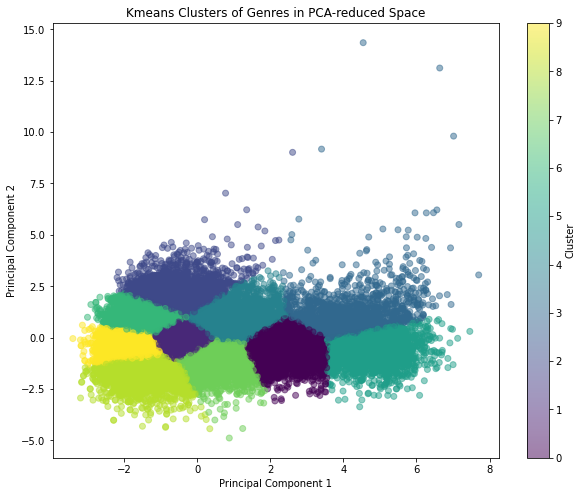

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import seed
import random
from scipy.stats import zscore
random.seed(13172760)

# Load data
data = pd.read_csv('//Users/mozhihao/Desktop/machine learning/project/musicData.csv')
data.replace('?', pd.NA, inplace=True)
data.replace(-1, pd.NA, inplace=True)
# Remove rows with any NaN values
data.dropna(inplace=True)

# Preprocessing
label_encoder = LabelEncoder()
data['key'] = label_encoder.fit_transform(data['key'].astype(str))

numeric_features = ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_features = ['mode', 'key']
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Encode music genres
genre_label_encoder = LabelEncoder()
data['music_genre'] = genre_label_encoder.fit_transform(data['music_genre'])

# Define features and labels
X = data.drop(['instance_id', 'artist_name', 'track_name', 'obtained_date', 'music_genre'], axis=1)
y = data['music_genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=13172760)

# Preprocessing: Fit and transform with the training data
X_combined_preprocessed = preprocessor.fit_transform(X)
# Apply PCA to only the scaled numerical features
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
X_train_pca = pca.fit_transform(X_combined_preprocessed)


# Check explained variance to understand the amount of information carried by the dimensions
explained_variance = pca.explained_variance_ratio_

# K-Means clustering
kmeans = KMeans(n_clusters=len(data['music_genre'].unique()), random_state=13172760)
clusters = kmeans.fit_predict(X_train_pca)

# Visualization of the clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.title('Kmeans Clusters of Genres in PCA-reduced Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster')
plt.show()



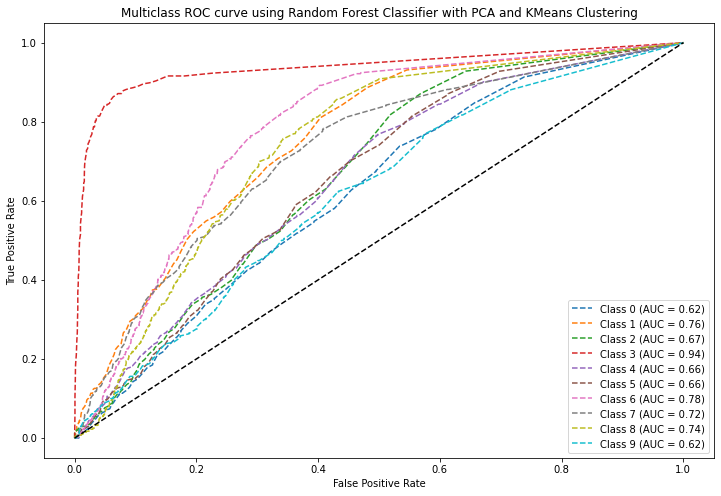

Macro Average AUC Score: 0.7159684359187682


In [2]:
from sklearn.metrics import roc_auc_score, roc_curve, auc as calculate_auc

# Ensure all numerical columns are of type float
numerical_cols = ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
data[numerical_cols] = data[numerical_cols].apply(pd.to_numeric, errors='coerce')

# Fill missing values with the mean of each column
data[numerical_cols] = data[numerical_cols].apply(lambda x: x.fillna(x.mean()), axis=0)



# Preprocessing pipelines for numeric and categorical data
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_features = ['mode', 'key']  # Example categorical features
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_features)
])

# Encode genre labels
label_encoder = LabelEncoder()
data['music_genre'] = label_encoder.fit_transform(data['music_genre'])

# Define features and labels
X = data.drop(['instance_id', 'artist_name', 'track_name', 'obtained_date', 'music_genre'], axis=1)
y = data['music_genre']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=13172760, stratify=y)

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# PCA for dimensionality reduction
pca = PCA(n_components=2, random_state=13172760)
X_train_pca = pca.fit_transform(X_train_processed)
X_test_pca = pca.transform(X_test_processed)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=10, random_state=13172760)  # Define the number of clusters
X_train_clusters = kmeans.fit_predict(X_train_pca)
X_test_clusters = kmeans.predict(X_test_pca)

# Enhance features with cluster labels
X_train_enhanced = np.hstack((X_train_pca, X_train_clusters[:, np.newaxis]))
X_test_enhanced = np.hstack((X_test_pca, X_test_clusters[:, np.newaxis]))

# Define the pipeline with RandomForest Classifier
pipeline = Pipeline(steps=[
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=13172760))
])

# Fit the model
pipeline.fit(X_train_enhanced, y_train)

# Predict probabilities
y_pred_proba = pipeline.predict_proba(X_test_enhanced)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='macro')

# Generate and plot ROC curve values for each class
fpr, tpr, thresh = {}, {}, {}
n_class = len(label_encoder.classes_)

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)

plt.figure(figsize=(12, 8))
for i in range(n_class):
    plt.plot(fpr[i], tpr[i], linestyle='--', label=f'Class {label_encoder.classes_[i]} (AUC = {calculate_auc(fpr[i], tpr[i]):.2f})')

plt.plot([0, 1], [0, 1], 'k--') ]
plt.title('Multiclass ROC curve using Random Forest Classifier with PCA and KMeans Clustering')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

print(f'Macro Average AUC Score: {roc_auc}')


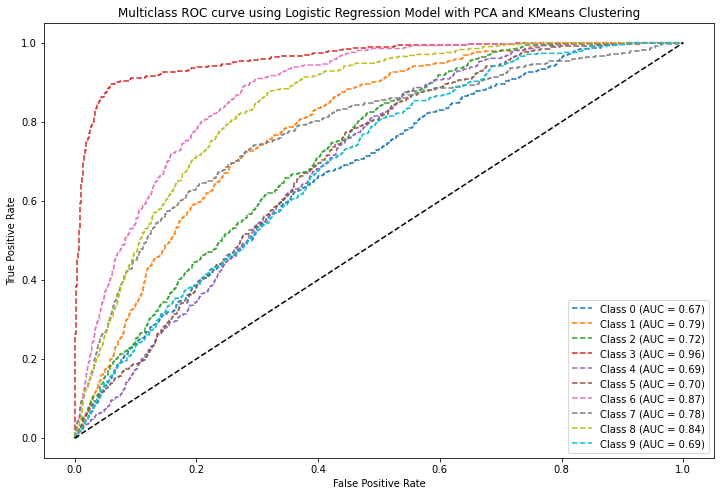

Macro Average AUC Score: 0.772092716078842


In [3]:
from sklearn.linear_model import LogisticRegression
# Append cluster labels to the PCA results
X_train_final = np.hstack((X_train_pca, X_train_clusters[:, np.newaxis]))
X_test_final = np.hstack((X_test_pca, X_test_clusters[:, np.newaxis]))

# Define the pipeline with logistic regression
pipeline = Pipeline(steps=[
    ('classifier', LogisticRegression(random_state=13172760, max_iter=1000))
])

# Fit the model
pipeline.fit(X_train_final, y_train)

# Predict probabilities and calculate ROC AUC score
y_pred_proba = pipeline.predict_proba(X_test_final)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='macro')

# Generate and plot ROC curve values for each class
fpr, tpr, thresh = {}, {}, {}
plt.figure(figsize=(12, 8))
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)
    plt.plot(fpr[i], tpr[i], linestyle='--', label=f'Class {label_encoder.classes_[i]} (AUC = {auc(fpr[i], tpr[i]):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # plot a line at chance level
plt.title('Multiclass ROC curve using Logistic Regression Model with PCA and KMeans Clustering')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

print(f'Macro Average AUC Score: {roc_auc}')


Iteration 1, loss = 1.91142896
Iteration 2, loss = 1.78968829
Iteration 3, loss = 1.77361686
Iteration 4, loss = 1.76756983
Iteration 5, loss = 1.76469173
Iteration 6, loss = 1.76295139
Iteration 7, loss = 1.76166929
Iteration 8, loss = 1.76026597
Iteration 9, loss = 1.75938272
Iteration 10, loss = 1.75915480
Iteration 11, loss = 1.75894526
Iteration 12, loss = 1.75820288
Iteration 13, loss = 1.75773564
Iteration 14, loss = 1.75739076
Iteration 15, loss = 1.75734689
Iteration 16, loss = 1.75669027
Iteration 17, loss = 1.75670473
Iteration 18, loss = 1.75659760
Iteration 19, loss = 1.75641513
Iteration 20, loss = 1.75609878
Iteration 21, loss = 1.75620766
Iteration 22, loss = 1.75590140
Iteration 23, loss = 1.75556982
Iteration 24, loss = 1.75566514
Iteration 25, loss = 1.75522394
Iteration 26, loss = 1.75533265
Iteration 27, loss = 1.75534604
Iteration 28, loss = 1.75487817
Iteration 29, loss = 1.75509019
Iteration 30, loss = 1.75472471
Iteration 31, loss = 1.75480642
Iteration 32, los

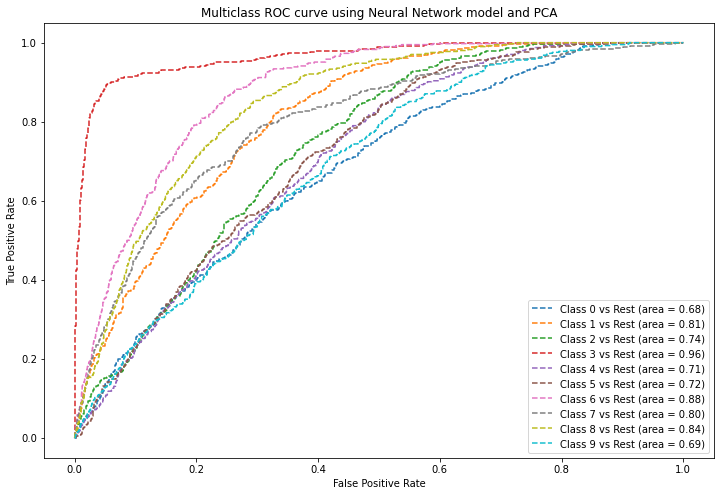

The AUC score of the model is: 0.7839089499596169


In [4]:
from sklearn.neural_network import MLPClassifier
# Neural Network model
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, alpha=1e-4,
                    solver='sgd', verbose=10, random_state=13172760,
                    learning_rate_init=.01)

# Train the model
mlp.fit(X_train_pca, y_train)

# Predict probabilities
y_pred_proba = mlp.predict_proba(X_test_pca)

# Calculate AUC
auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')


fpr = {}
tpr = {}
thresh ={}
n_class = len(np.unique(y_test))

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_proba[:,i], pos_label=i)
plt.figure(figsize=(12, 8))   
# Plotting
for i in range(n_class):
    plt.plot(fpr[i], tpr[i], linestyle='--', 
             label='Class %s vs Rest (area = %0.2f)' % (i, auc(fpr[i], tpr[i])))

plt.title('Multiclass ROC curve using Neural Network model and PCA')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()
print(f"The AUC score of the model is: {auc_score}")



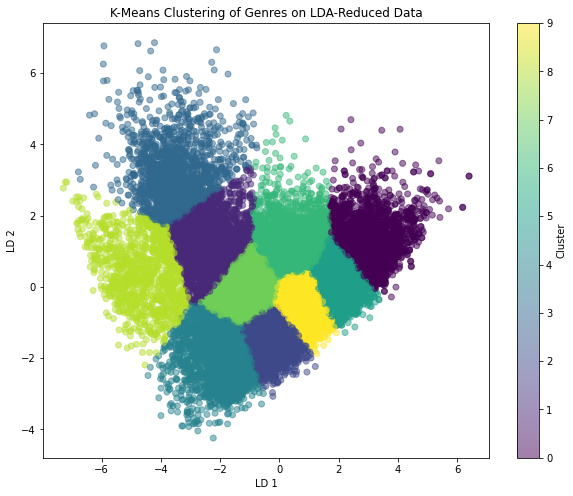

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import seed
import random
from scipy.stats import zscore
random.seed(13172760)

# Load data
data = pd.read_csv('//Users/mozhihao/Desktop/machine learning/project/musicData.csv')
data.replace('?', pd.NA, inplace=True)
data.replace(-1, pd.NA, inplace=True)
# Remove rows with any NaN values
data.dropna(inplace=True)

# Preprocessing
label_encoder = LabelEncoder()
data['key'] = label_encoder.fit_transform(data['key'].astype(str))

numeric_features = ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_features = ['mode', 'key']
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Encode music genres
genre_label_encoder = LabelEncoder()
data['music_genre'] = genre_label_encoder.fit_transform(data['music_genre'])

# Define features and labels
X = data.drop(['instance_id', 'artist_name', 'track_name', 'obtained_date', 'music_genre'], axis=1)
y = data['music_genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=13172760)


X_combined_preprocessed = preprocessor.fit_transform(X_train)

# Apply LDA
lda = LDA(n_components=2)  
X_train_lda = lda.fit_transform(X_combined_preprocessed, y_train)

# K-means clustering on the LDA reduced data
kmeans = KMeans(n_clusters=10, random_state=13172760) 
clusters = kmeans.fit_predict(X_train_lda)

# Visualization of LDA results and clustering
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_lda[:, 0], X_train_lda[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.title('K-Means Clustering of Genres on LDA-Reduced Data')
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.colorbar(scatter, label='Cluster')
plt.show()


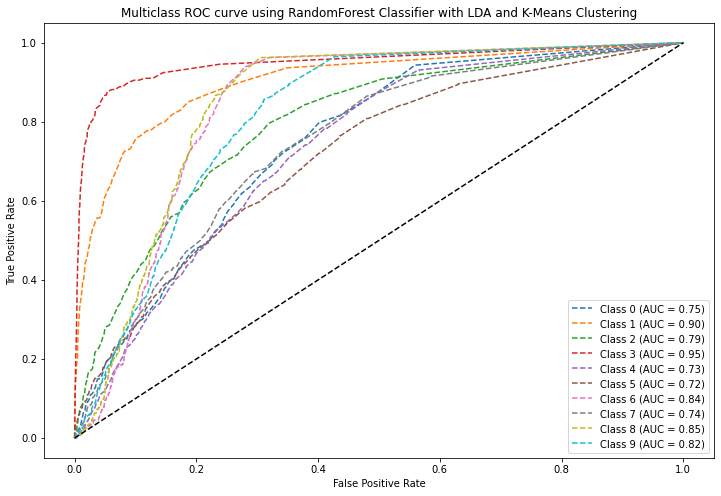

Macro Average AUC Score: 0.8078447863283251


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import seed
import random
random.seed(13172760)

# Load data
data = pd.read_csv('//Users/mozhihao/Desktop/machine learning/project/musicData.csv')
data.replace('?', pd.NA, inplace=True)
data.replace(-1, pd.NA, inplace=True)
data.dropna(inplace=True)

# Preprocessing
label_encoder = LabelEncoder()
data['key'] = label_encoder.fit_transform(data['key'].astype(str))
data['music_genre'] = label_encoder.fit_transform(data['music_genre'])

numeric_features = ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_features = ['mode', 'key']
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Define features and labels
X = data.drop(['instance_id', 'artist_name', 'track_name', 'obtained_date', 'music_genre'], axis=1)
y = data['music_genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=13172760)

# LDA and K-means as combined feature transformation
class LDAKMeans(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=2, n_clusters=10):
        self.lda = LDA(n_components=n_components)
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=13172760)

    def fit(self, X, y=None):
        self.features = self.lda.fit_transform(X, y)
        self.kmeans.fit(self.features)
        return self

    def transform(self, X, y=None):
        features = self.lda.transform(X)
        cluster_distances = self.kmeans.transform(features)
        return np.hstack((features, cluster_distances))

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_transformation', LDAKMeans(n_components=2, n_clusters=10)),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=None, random_state=13172760))
])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict probabilities
y_pred_proba = pipeline.predict_proba(X_test)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='macro')

# Generate and plot ROC curve values for each class
fpr = {}
tpr = {}
thresh = {}
n_class = len(label_encoder.classes_)

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)

plt.figure(figsize=(12, 8))
for i in range(n_class):
    plt.plot(fpr[i], tpr[i], linestyle='--', label=f'Class {label_encoder.classes_[i]} (AUC = {auc(fpr[i], tpr[i]):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # plot a line at chance level
plt.title('Multiclass ROC curve using RandomForest Classifier with LDA and K-Means Clustering')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

print(f'Macro Average AUC Score: {roc_auc}')



Iteration 1, loss = 1.56068580
Iteration 2, loss = 1.49543222
Iteration 3, loss = 1.48495856
Iteration 4, loss = 1.47977810
Iteration 5, loss = 1.47620058
Iteration 6, loss = 1.47138020
Iteration 7, loss = 1.47021397
Iteration 8, loss = 1.46643944
Iteration 9, loss = 1.46687477
Iteration 10, loss = 1.46385691
Iteration 11, loss = 1.46361192
Iteration 12, loss = 1.46292235
Iteration 13, loss = 1.46027996
Iteration 14, loss = 1.46177569
Iteration 15, loss = 1.45831703
Iteration 16, loss = 1.46210906
Iteration 17, loss = 1.45813992
Iteration 18, loss = 1.45832126
Iteration 19, loss = 1.45986660
Iteration 20, loss = 1.45979398
Iteration 21, loss = 1.45840344
Iteration 22, loss = 1.45903860
Iteration 23, loss = 1.45805815
Iteration 24, loss = 1.45954755
Iteration 25, loss = 1.45665388
Iteration 26, loss = 1.45598555
Iteration 27, loss = 1.45802700
Iteration 28, loss = 1.45710153
Iteration 29, loss = 1.45799798
Iteration 30, loss = 1.45779126
Iteration 31, loss = 1.45710549
Iteration 32, los

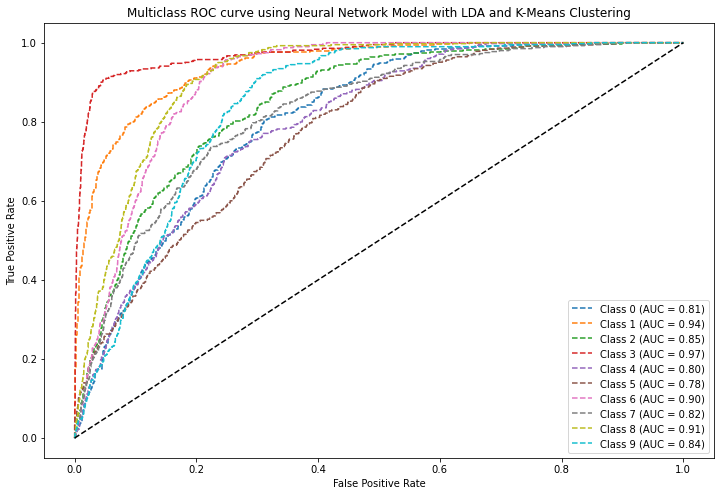

Macro Average AUC Score: 0.8620992813390415


In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline



# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_transformation', LDAKMeans(n_components=2, n_clusters=10)),
    ('classifier', MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, alpha=1e-4,
                                 solver='adam', verbose=10, random_state=13172760,
                                 learning_rate_init=.01))
])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict probabilities
y_pred_proba = pipeline.predict_proba(X_test)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='macro')

# Generate and plot ROC curve values for each class
fpr = {}
tpr = {}
thresh = {}
n_class = len(label_encoder.classes_)

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)

plt.figure(figsize=(12, 8))
for i in range(n_class):
    plt.plot(fpr[i], tpr[i], linestyle='--', label=f'Class {label_encoder.classes_[i]} (AUC = {auc(fpr[i], tpr[i]):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # plot a line at chance level
plt.title('Multiclass ROC curve using Neural Network Model with LDA and K-Means Clustering')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

print(f'Macro Average AUC Score: {roc_auc}')



/Users/mozhihao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


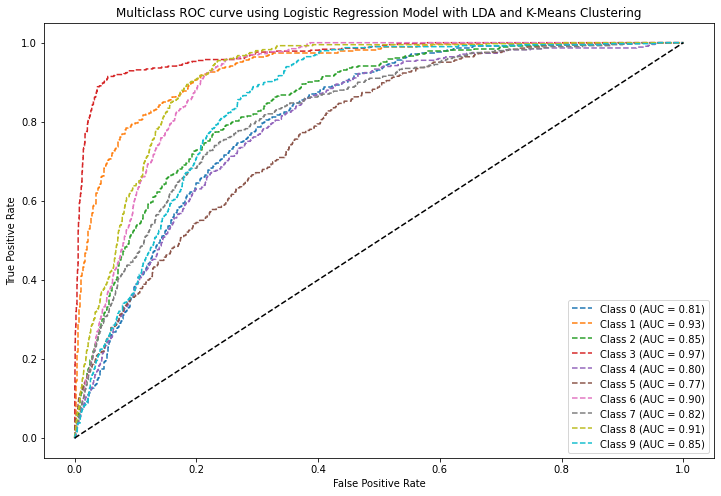

Macro Average AUC Score: 0.8615636160167484


In [8]:
from sklearn.linear_model import LogisticRegression

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_transformation', LDAKMeans(n_components=2, n_clusters=10)),
    ('classifier', LogisticRegression(max_iter=100, random_state=13172760))
])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict probabilities
y_pred_proba = pipeline.predict_proba(X_test)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='macro')

# Generate and plot ROC curve values for each class
fpr = {}
tpr = {}
thresh = {}
n_class = len(label_encoder.classes_)

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)

plt.figure(figsize=(12, 8))
for i in range(n_class):
    plt.plot(fpr[i], tpr[i], linestyle='--', label=f'Class {label_encoder.classes_[i]} (AUC = {auc(fpr[i], tpr[i]):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # plot a line at chance level
plt.title('Multiclass ROC curve using Logistic Regression Model with LDA and K-Means Clustering')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

print(f'Macro Average AUC Score: {roc_auc}')


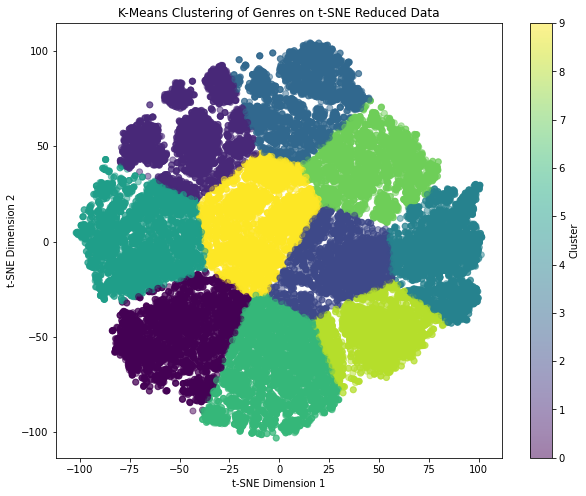

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import seed
import random
from scipy.stats import zscore
random.seed(13172760)

# Load data
data = pd.read_csv('//Users/mozhihao/Desktop/machine learning/project/musicData.csv')
data.replace('?', pd.NA, inplace=True)
data.replace(-1, pd.NA, inplace=True)
# Remove rows with any NaN values
data.dropna(inplace=True)

# Preprocessing
label_encoder = LabelEncoder()
data['key'] = label_encoder.fit_transform(data['key'].astype(str))

numeric_features = ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_features = ['mode', 'key']
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Encode music genres
genre_label_encoder = LabelEncoder()
data['music_genre'] = genre_label_encoder.fit_transform(data['music_genre'])

# Define features and labels
X = data.drop(['instance_id', 'artist_name', 'track_name', 'obtained_date', 'music_genre'], axis=1)
y = data['music_genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=13172760)

# Preprocessing: Fit and transform with the training data
X_combined_preprocessed = preprocessor.fit_transform(X_train)

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=13172760)  # Reduce to 2 dimensions for visualization and analysis
X_train_tsne = tsne.fit_transform(X_combined_preprocessed)

# K-means clustering on the t-SNE reduced data
kmeans = KMeans(n_clusters=10, random_state=13172760)  # Adjust clusters as needed
clusters = kmeans.fit_predict(X_train_tsne)

# Visualization of t-SNE results and clustering
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.title('K-Means Clustering of Genres on t-SNE Reduced Data')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(scatter, label='Cluster')
plt.show()


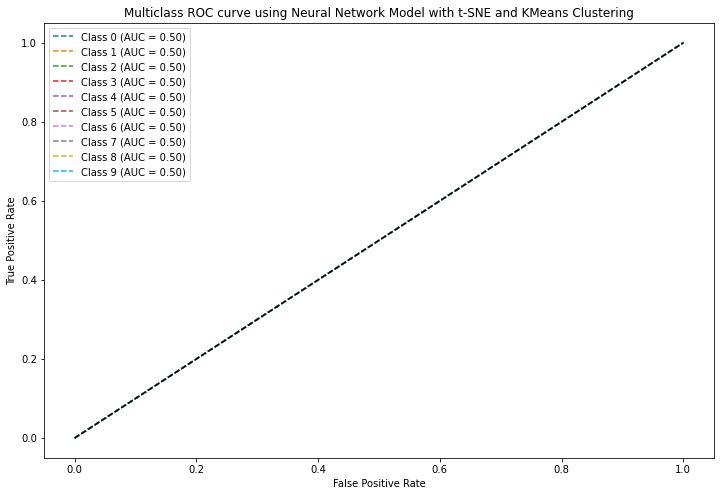

Macro Average AUC Score: 0.5


In [23]:

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc

kmeans.fit(X_train_tsne)
X_train_km = kmeans.transform(X_train_tsne)
X_test_km = kmeans.transform(X_test_tsne)

# Combine t-SNE and K-means results with original features
X_train_combined = np.hstack((X_train_tsne, X_train_km))
X_test_combined = np.hstack((X_test_tsne, X_test_km))

# Neural Network training
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, alpha=1e-4,
                    solver='adam', verbose=False, random_state=13172760,
                    learning_rate_init=.1)
mlp.fit(X_train_combined, y_train)

# Predict probabilities and compute AUC
y_pred_proba = mlp.predict_proba(X_test_combined)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='macro')

# Generate and plot ROC curve values for each class
fpr, tpr, thresh = {}, {}, {}
n_class = len(label_encoder.classes_)

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)

plt.figure(figsize=(12, 8))
for i in range(n_class):
    plt.plot(fpr[i], tpr[i], linestyle='--', label=f'Class {label_encoder.classes_[i]} (AUC = {calculate_auc(fpr[i], tpr[i]):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('Multiclass ROC curve using Neural Network Model with t-SNE and KMeans Clustering')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

print(f'Macro Average AUC Score: {roc_auc}')



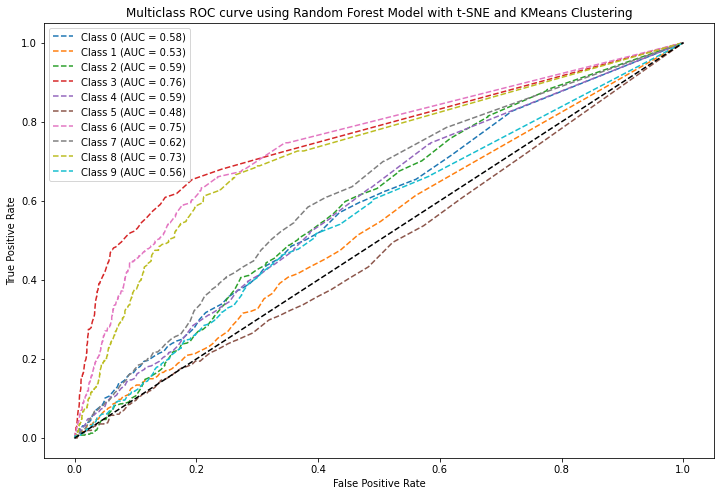

Macro Average AUC Score: 0.6188722792742568


In [24]:

# Train a Random Forest model
random_forest = RandomForestClassifier(n_estimators=100, random_state=13172760)
random_forest.fit(X_train_combined, y_train)

# Predict probabilities
y_pred_proba = random_forest.predict_proba(X_test_combined)

# Calculate AUC
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='macro')

# Generate and plot ROC curve values for each class
fpr, tpr, thresh = {}, {}, {}
n_class = len(label_encoder.classes_)

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)

plt.figure(figsize=(12, 8))
for i in range(n_class):
    plt.plot(fpr[i], tpr[i], linestyle='--', label=f'Class {label_encoder.classes_[i]} (AUC = {calculate_auc(fpr[i], tpr[i]):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('Multiclass ROC curve using Random Forest Model with t-SNE and KMeans Clustering')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

print(f'Macro Average AUC Score: {roc_auc}')


/Users/mozhihao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


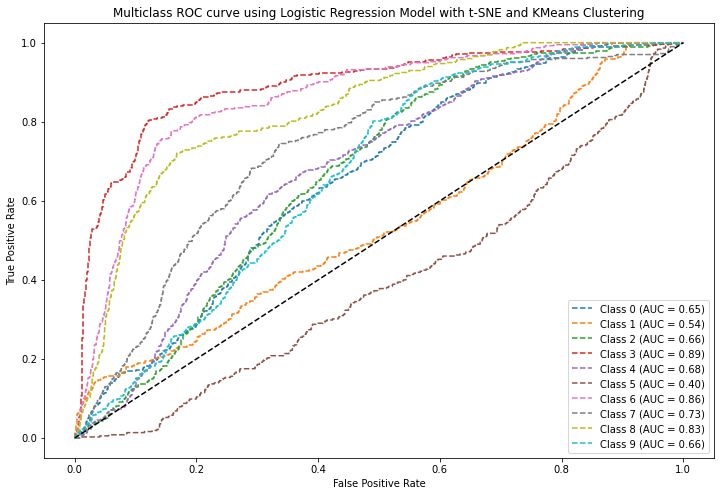

Macro Average AUC Score: 0.6903715403683208


In [25]:
# Train a Logistic Regression model
log_reg = LogisticRegression(max_iter=300, random_state=13172760)
log_reg.fit(X_train_combined, y_train)

# Predict probabilities
y_pred_proba = log_reg.predict_proba(X_test_combined)

# Calculate AUC
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')

# Generate and plot ROC curve values for each class
fpr, tpr, thresh = {}, {}, {}
n_class = len(label_encoder.classes_)

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)

plt.figure(figsize=(12, 8))
for i in range(n_class):
    plt.plot(fpr[i], tpr[i], linestyle='--', label=f'Class {label_encoder.classes_[i]} (AUC = {calculate_auc(fpr[i], tpr[i]):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('Multiclass ROC curve using Logistic Regression Model with t-SNE and KMeans Clustering')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

print(f'Macro Average AUC Score: {roc_auc}')
